PYTHON 3

# Sommaire

>[Sommaire](#scrollTo=WYyCyOO_r6lw)

>[Imports classiques](#scrollTo=I4oNLLIcsJcg)

>[Mise en place matérielle de l'environnement](#scrollTo=mkb9LHR1r_O0)

>>[Copie des fichiers du drive vers la machine distante](#scrollTo=8CFQXIRpwsFV)

>[Chargement des données](#scrollTo=uMGcEvsOzyHe)

>[Initialisation du modèle de ML](#scrollTo=5rs8lLzQxNYJ)

>[Training](#scrollTo=6finyiXVyRIq)

>[Test du modèle](#scrollTo=X91E4eY62iJR)

>[Sauvegarde des fichiers sur le drive](#scrollTo=aVHU4uZ77k_v)



# Imports classiques

In [139]:

!pip install tqdm

from tqdm import tqdm

from keras import backend as K

K.set_image_dim_ordering('th')

# Mise en place matérielle de l'environnement

## Copie des fichiers du drive vers la machine distante

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


def uploadToDistantMachineFolder(driveFolderId,targetPath="~") :
  
  # Authentification et initialisation du client PyDrive
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Choix d'un répertoire distant pour charger les donnéelocal_download_path = os.path.expanduser('~')
  try:
    os.makedirs(targetPath)
  except: pass

  # Ciblage du dossier drive contenant les données
  folderID = driveFolderId # les données se trouvent dans mon drive à l'URL https://drive.google.com/drive/u/0/folders/<>
  file_list = drive.ListFile({'q': "'{}' in parents".format(folderID)}).GetList()

  for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = os.path.join(targetPath, f['title'])
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

In [141]:
uploadToDistantMachineFolder("1ggpBuvJLQir2dJuNYuoYgcCjPADgg82O")

title: bddBabyAIAll_valid.csv, id: 15dWrXSfyerB_x5w1MFBLGEUXhGGGT5y5
downloading to ~/bddBabyAIAll_valid.csv
title: bddBabyAIAll_train.csv, id: 18QAbwYoliyRccTndoTgNcmhcNLBLvcW3
downloading to ~/bddBabyAIAll_train.csv
title: bddBabyAIAll_test.csv, id: 1e5fpwAHr0SABTWxhsf4pYhstLVN-wzjq
downloading to ~/bddBabyAIAll_test.csv
title: bddBabyAIAl_train .csv, id: 1bgfIThQkQywxhsMaxVkHndka9wWnuRNG
downloading to ~/bddBabyAIAl_train .csv


Vérifier que les donnée sont bien chargées

In [142]:
from google.colab import files

files.os.listdir("~")

['bddBabyAIAll_train.csv',
 'bddBabyAIAll_valid.csv',
 'bddBabyAIAll_test.csv',
 'bddBabyAIAl_train .csv']

# Chargement des données

In [0]:
import pandas as pd
import numpy as np
import math

def load_data(path) :
    data = pd.read_csv(path)
    X = data.loc[:, ["pixel"+str(i) for i in range(1024)]].values.astype('float32')
    y = data.loc[:, ["shape"]].values.astype('int32')
    arr = np.arange(X.shape[0])
    np.random.shuffle(arr)    
    
    X_train = np.zeros((X.shape[0],X.shape[1]))
    Y_train = np.zeros((X.shape[0],3))
    y_train = np.zeros((X.shape[0],1))
    
    for i in range(X.shape[0]):
      X_train[i] = X[arr[i]]
      y_train[i] = y[arr[i]]
      try:
        Y_train[i,int(y_train[i])] = 1
      except:
        print(y[i])
    X_train = X_train.reshape(X_train.shape[0],1,32,32)

    return X_train,Y_train

In [0]:
X_train,Y_train = load_data("bddBabyAIAll_train.csv")
X_test, Y_test = load_data("bddBabyAIAll_test.csv")

# Initialisation du modèle de ML

In [0]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, Adagrad
from keras import initializers

In [0]:
def classifier() :
  
  model = Sequential()
  
  model.add(Conv2D(32, (3, 3), input_shape=(1,32,32), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  
  model.add(Dense(128))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(32))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.3))
  
  model.add(Dense(3, activation='softmax'))
  
  return model

# Training

## Entrainement du classifieur

In [0]:
from keras.callbacks import ModelCheckpoint

def train(model, X, Y, epochs=1, batchSize=128, validation=None):
  
    batchCount = X.shape[0]//batchSize+1
    
    # Affichage des paramètres de train
    print('Epochs:',epochs)
    print('Batch size:',batchSize)
    print('Batches per epoch:',batchCount)
    
    # Programmation des sauvegardes des epochs
    filepath="weights_{epoch:02d}_{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # on entraine le réseau en enregistrant les données de train de toutes les epoch
    history = model.fit(X,Y,batch_size=batchSize,epochs=epochs,validation_data=validation,callbacks=callbacks_list,verbose=2)
    
    return history

In [148]:
model = classifier()
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

epochs = 70
batchSize = 128

history = train(model,X_train,Y_train,epochs,batchSize,(X_test,Y_test))

Epochs: 70
Batch size: 128
Batches per epoch: 625
Train on 79992 samples, validate on 39992 samples
Epoch 1/70
 - 11s - loss: 0.4090 - acc: 0.8156 - val_loss: 0.2710 - val_acc: 0.8949

Epoch 00001: val_acc improved from -inf to 0.89487, saving model to weights_01_0.89.hdf5
Epoch 2/70
 - 10s - loss: 0.2536 - acc: 0.8995 - val_loss: 0.2005 - val_acc: 0.9207

Epoch 00002: val_acc improved from 0.89487 to 0.92070, saving model to weights_02_0.92.hdf5
Epoch 3/70
 - 10s - loss: 0.2022 - acc: 0.9196 - val_loss: 0.1668 - val_acc: 0.9338

Epoch 00003: val_acc improved from 0.92070 to 0.93378, saving model to weights_03_0.93.hdf5
Epoch 4/70
 - 10s - loss: 0.1747 - acc: 0.9308 - val_loss: 0.1442 - val_acc: 0.9419

Epoch 00004: val_acc improved from 0.93378 to 0.94192, saving model to weights_04_0.94.hdf5
Epoch 5/70
 - 10s - loss: 0.1560 - acc: 0.9381 - val_loss: 0.1256 - val_acc: 0.9502

Epoch 00005: val_acc improved from 0.94192 to 0.95017, saving model to weights_05_0.95.hdf5
Epoch 6/70
 - 10s 


Epoch 00023: val_acc did not improve from 0.98278
Epoch 24/70
 - 10s - loss: 0.0632 - acc: 0.9762 - val_loss: 0.0458 - val_acc: 0.9822

Epoch 00024: val_acc did not improve from 0.98278
Epoch 25/70
 - 10s - loss: 0.0618 - acc: 0.9766 - val_loss: 0.0450 - val_acc: 0.9832

Epoch 00025: val_acc improved from 0.98278 to 0.98321, saving model to weights_25_0.98.hdf5
Epoch 26/70
 - 10s - loss: 0.0607 - acc: 0.9774 - val_loss: 0.0431 - val_acc: 0.9846

Epoch 00026: val_acc improved from 0.98321 to 0.98463, saving model to weights_26_0.98.hdf5
Epoch 27/70
 - 10s - loss: 0.0591 - acc: 0.9774 - val_loss: 0.0418 - val_acc: 0.9842

Epoch 00027: val_acc did not improve from 0.98463
Epoch 28/70
 - 10s - loss: 0.0566 - acc: 0.9787 - val_loss: 0.0421 - val_acc: 0.9844

Epoch 00028: val_acc did not improve from 0.98463
Epoch 29/70
 - 10s - loss: 0.0553 - acc: 0.9795 - val_loss: 0.0392 - val_acc: 0.9858

Epoch 00029: val_acc improved from 0.98463 to 0.98581, saving model to weights_29_0.99.hdf5
Epoch 3


Epoch 00048: val_acc improved from 0.98907 to 0.98948, saving model to weights_48_0.99.hdf5
Epoch 49/70
 - 10s - loss: 0.0407 - acc: 0.9851 - val_loss: 0.0303 - val_acc: 0.9887

Epoch 00049: val_acc did not improve from 0.98948
Epoch 50/70
 - 10s - loss: 0.0404 - acc: 0.9853 - val_loss: 0.0279 - val_acc: 0.9899

Epoch 00050: val_acc improved from 0.98948 to 0.98986, saving model to weights_50_0.99.hdf5
Epoch 51/70
 - 10s - loss: 0.0393 - acc: 0.9858 - val_loss: 0.0288 - val_acc: 0.9894

Epoch 00051: val_acc did not improve from 0.98986
Epoch 52/70
 - 10s - loss: 0.0396 - acc: 0.9859 - val_loss: 0.0280 - val_acc: 0.9898

Epoch 00052: val_acc did not improve from 0.98986
Epoch 53/70
 - 9s - loss: 0.0402 - acc: 0.9857 - val_loss: 0.0287 - val_acc: 0.9893

Epoch 00053: val_acc did not improve from 0.98986
Epoch 54/70
 - 9s - loss: 0.0397 - acc: 0.9858 - val_loss: 0.0292 - val_acc: 0.9895

Epoch 00054: val_acc did not improve from 0.98986
Epoch 55/70
 - 10s - loss: 0.0379 - acc: 0.9863 - v

## Affichage des données de train

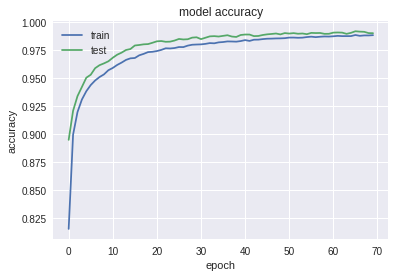

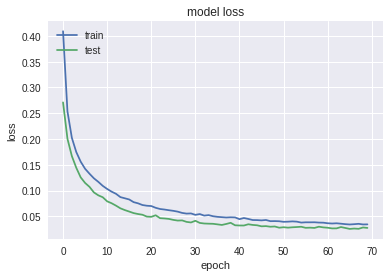

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

# Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy')

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss')

## Enregistrement des données de train avec Pickle

In [0]:
import pickle

data = {'acc':history.history['acc'][:],
        'val_acc':history.history['val_acc'][:],
        'loss':history.history['loss'][:],
        'val_loss':history.history['val_loss'][:]}

with open (r"history.txt","wb") as f:
  pickle.dump(data, f)
  
  
from google.colab import files

files.download('history.txt')


# Test du modèle

In [0]:
from math import sqrt

def test(model, X, Y) :
  
  correct = 0
  
  for ID in range(X.shape[0]) :
    if np.argmax(model.predict(np.array([X[ID,:],]))) == np.argmax(Y[ID]) :
      correct += 1
      
  tau = correct/X.shape[0]
  barre = sqrt(tau*(1-tau)/X.shape[0])
  
  print("Tgen =",tau,"+-",barre)

In [152]:
test(model, X_test, Y_test)

Tgen = 0.9847219443888777 +- 0.0006133442377062238


# Sauvegarde des fichiers en local

In [0]:
from google.colab import files

hdf = []

for file in files.os.listdir("/content/") :
  
    if ".hdf5" in file :
        hdf.append(file)
        #files.download("/content/"+file)
    #if ".png" in file :
    #    files.download("/content/"+file)
hdf.sort()
files.download("/content/"+hdf[-1])
